In [1]:
import pandas as pd
import os, datetime
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pysandag.database import get_connection_string
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
db_connection_string = get_connection_string('..\data\config.yml', 'mssql_db')
mssql_engine = create_engine(db_connection_string)

## Get subregional simulation output

In [3]:
# get max run id from urbansim
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)
print("\n   Max run id : {:,}".format(run_id))

hs_change_sql = '''
    SELECT o.parcel_id, j.name,  p.cap_jurisdiction_id, p.jurisdiction_id, p.mgra_id, p.luz_id,
    unit_change as hs_change, source, year_simulation
      FROM urbansim.urbansim.urbansim_lite_output o 
      JOIN urbansim.urbansim.parcel p on p.parcel_id = o.parcel_id
      JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id
     WHERE run_id =  %s
  ORDER BY j.name,p.jurisdiction_id, year_simulation'''
hs_change_sql = hs_change_sql % run_id
hs = pd.read_sql(hs_change_sql,mssql_engine)
print("\n   Units added: {:,}".format(int(hs.hs_change.sum())))


   Max run id : 21

   Units added: 468,866


## Get SR13 results

In [ ]:
sr13_sql = '''
select x.mgra, sum([hs]) AS hs, increment, city, cpa, x.luz as luz_id,site
from [regional_forecast].[sr13_final].[capacity] x
join [regional_forecast].[sr13_final].[mgra13] y
on x.mgra = y.mgra
where scenario = 0 
group by x.mgra, site, increment, y.city,y.cpa,x.luz
order by x.mgra, increment'''
sr13_df = pd.read_sql(sr13_sql, mssql_engine)
# count results
nmgra = int(len(sr13_df.mgra.unique()))
nincrements = int(len(sr13_df.increment.unique()))
lendf = int(len(sr13_df))
duplicated_df = sr13_df[sr13_df.duplicated(subset=['mgra','increment'], keep="first")]
numdup = int(len(duplicated_df))
mi = nmgra*nincrements
nodups = lendf - numdup

In [ ]:
print("\n   Number of increments: {:,}".format(nincrements))
print("\n   Number of mgras: {:,}".format(nmgra))
print("\n        increments * mgras: {:,}".format(mi))
print("\nsr13 dataframe length: {:,}".format(lendf))
print("\n   Number of duplicates: {:,}  (mgra w site id and not site id)".format(numdup))

## QC check output against jurisdiction feedback confluence pg (since all capacity used)

https://sandag.atlassian.net/wiki/spaces/LUM/pages/101679105/Jurisdictional+Feedback

In [ ]:
jur_cap_df = pd.DataFrame({'units_change': hs.groupby(['cap_jurisdiction_id']).hs_change.sum()}).reset_index()
jur_cap_df.set_index('cap_jurisdiction_id',inplace=True)
# jur_cap_df

## Get total dwelling units in the region and sum by jurisdiction and cpa

#### note using cap jurisdiction id

In [ ]:
du_sql = '''
    SELECT parcel_id, mgra_id, luz_id, p.jurisdiction_id, cap_jurisdiction_id, j.name, du_2015 as du, du_2017, capacity_2
        FROM urbansim.parcel p
        LEFT JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id'''
#        WHERE du_2017 > 0'''
du = pd.read_sql(du_sql,mssql_engine)
du.cap_jurisdiction_id.fillna(du.jurisdiction_id,inplace=True) # where there is no cap jurisdiction id 
print("\n   Dwelling Units 2015: {:,}".format(int(du.du.sum())))
print("\n   Dwelling Units 2017: {:,}".format(int(du.du_2017.sum())))

In [ ]:
du_sql = '''
    SELECT parcel_id, mgra_id, luz_id, p.jurisdiction_id, cap_jurisdiction_id, j.name, du_2015 as du, du_2017, capacity_2
        FROM urbansim.parcel p
        LEFT JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id
        WHERE du_2017 > 0 or du_2015 > 0'''
du = pd.read_sql(du_sql,mssql_engine)
du.cap_jurisdiction_id.fillna(du.jurisdiction_id,inplace=True) # where there is no cap jurisdiction id 
print("\n   Dwelling Units 2015: {:,}".format(int(du.du.sum())))
print("\n   Dwelling Units 2017: {:,}".format(int(du.du_2017.sum())))

## Get CPAs for city and county

#### complete list for plotting even if no housing stock change, i.e. plot zero for those with no change

In [ ]:
xref_geography_sql = '''
    SELECT mgra_13, cocpa_2016, cicpa_13,cocpa_13, jurisdiction_2016, 
           COALESCE(cocpa_2016,cicpa_13,cocpa_13) as CPAs
      FROM data_cafe.ref.vi_xref_geography_mgra_13'''
xref_geography_df = pd.read_sql(xref_geography_sql, mssql_engine)

In [ ]:
len(xref_geography_df)

#### get unique CPAs

In [ ]:
CPAs = xref_geography_df.loc[~xref_geography_df.CPAs.isnull()].CPAs.unique().tolist()

#### set jurisdiction id 14 and 19 to CPA otherwise use jurisdiction id

In [ ]:
# simulation output
units = pd.merge(hs,xref_geography_df,left_on='mgra_id',right_on='mgra_13',how='left')
units.loc[units.cap_jurisdiction_id == 19,'jcid'] = units['cocpa_2016']
units.loc[units.cap_jurisdiction_id == 14,'jcid'] = units['cicpa_13']
units['jcid'].fillna(units['cap_jurisdiction_id'],inplace=True)

In [ ]:
len(units)

In [ ]:
len(hs)

#### Check for nulls and 14 and 19 instead of cpa as id

In [ ]:
# manually assign CPA to mgra 19415, 18831
units.loc[units.mgra_id==19415,'jcid'] = 1909
units.loc[units.mgra_id==18831,'jcid'] = 1909

In [ ]:
units.loc[units.jcid.isnull()]

In [ ]:
units.loc[units.jcid==14]

In [ ]:
units.loc[units.jcid==19]

####  Add CPAs where there was no unit change to complete dataset 

In [ ]:
units.parcel_id = units.parcel_id.astype(int)
units.jcid = units.jcid.astype(int)

In [ ]:
units.set_index('jcid',inplace=True)

In [ ]:
# units.head()

In [ ]:
jcids = units.index.unique().tolist()

In [ ]:
CPAs_no_unit_change = np.setdiff1d(CPAs,jcids).tolist()

In [ ]:
CPAs_no_unit_change

In [ ]:
for cpa in CPAs_no_unit_change:
    units.loc[cpa] = np.nan

In [ ]:
units.reset_index(inplace=True)

In [ ]:
len(units.jcid.unique())

In [ ]:
units.fillna(0,inplace=True)

In [ ]:
# mgras where issues: 19415, 18831, 11514, 7521, 7259
# manually assign CAP to mgra_13 7259
# units.loc[units.mgra_13==7259,'jcid'] = 1439 # otherwise uses jurisdiction_2016 as 14

In [ ]:
# units.tail()

In [ ]:
# dwelling units
dus = pd.merge(du,xref_geography_df,left_on='mgra_id',right_on='mgra_13',how = 'left')
dus.loc[dus.cap_jurisdiction_id == 19,'jcid'] = dus['cocpa_2016']
dus.loc[dus.cap_jurisdiction_id == 14,'jcid'] = dus['cicpa_13']
dus['jcid'].fillna(dus['cap_jurisdiction_id'],inplace=True)

In [ ]:
# manually assign CPA or jurisdiction to mgra 19415,11514,18831
dus.loc[dus.mgra_id==19415,'jcid'] = 1909
dus.loc[dus.mgra_id==18831,'jcid'] = 1909
dus.loc[dus.mgra_id==11514.0,'jcid'] = 13
dus.loc[dus.mgra_id==7521.0,'jcid'] = 3
# dus.loc[dus.mgra_13==7259,'jcid'] = 1439 

In [ ]:
dus.loc[dus.jcid.isnull()]

In [ ]:
dus.loc[dus.jcid==14]

In [ ]:
dus.loc[dus.jcid==19]

## fill in zero for CPAs with no dwelling units

In [ ]:
dus.set_index('jcid',inplace=True)

In [ ]:
jcids = dus.index.unique().tolist()
CPAs_no_unit_change = np.setdiff1d(CPAs,jcids).tolist()
CPAs_no_unit_change

In [ ]:
for cpa in CPAs_no_unit_change:
    dus.loc[cpa] = np.nan

In [ ]:
dus.reset_index(inplace=True)

In [ ]:
dus.fillna(0,inplace=True)

In [ ]:
len(dus.jcid.unique())

In [ ]:
dus.parcel_id = dus.parcel_id.astype(int)
dus.jcid = dus.jcid.astype(int)

## use sql query to find nearest CPA if necessary

### Add cpa name

In [ ]:
cocpa_names_sql = '''
    SELECT zone as cocpa_id, name as cocpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 20'''
cocpa_names = pd.read_sql(cocpa_names_sql, mssql_engine)
cicpa_names_sql = '''
    SELECT zone as cicpa_id, name as cicpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 15'''
cicpa_names = pd.read_sql(cicpa_names_sql, mssql_engine)
luz_names_sql = '''
    SELECT zone as luz_id, name as luz
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 64'''
luz_names = pd.read_sql(luz_names_sql, mssql_engine)    
jurisdictions_names_sql = '''
    SELECT zone as jurisdiction_id, name as jurisdiction
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 150'''
jur_name_df = pd.read_sql(jurisdictions_names_sql, mssql_engine)

In [ ]:
units = pd.merge(units,cocpa_names,left_on='jcid',right_on='cocpa_id',how = 'left')
units = pd.merge(units,cicpa_names,left_on='jcid',right_on='cicpa_id',how = 'left')
units = pd.merge(units,jur_name_df,left_on='jurisdiction_2016',right_on='jurisdiction_id',how = 'left')

In [ ]:
units['jcname'] = units['name']
units.loc[units.jcid>=1900,'jcname'] = units['cocpa']
units.loc[(units.jcid>=1400) & (units.jcid<1900),'jcname'] = units['cicpa']
units.loc[units.jcname==0,'jcname'] = units['jurisdiction']

In [ ]:
units.sort_values(by='jcid').jcid.unique()

In [ ]:
# check that there are no nulls values (should equal 103)
len(units.jcname.unique())

In [ ]:
units.loc[units.year_simulation==0,'year_simulation'] = 2017

#### check results again to match jurisdiction feedback page

In [ ]:
change_df = pd.DataFrame({'chg': units.groupby(['jcid','jcname']).
                               hs_change.sum()}).reset_index()
change_df['jcid'] =change_df['jcid'].astype(int)
change_df.set_index('jcid',inplace=True)
# change_df

## Get CPAs for city and county for sr13

In [ ]:
sr13_df = pd.merge(sr13_df,jur_name_df[['jurisdiction_id','jurisdiction']],left_on='city',right_on='jurisdiction_id')
sr13_df = pd.merge(sr13_df,cocpa_names[['cocpa_id','cocpa']],left_on='cpa',right_on='cocpa_id', how = 'outer')
sr13_df = pd.merge(sr13_df,cicpa_names[['cicpa_id','cicpa']],left_on='cpa',right_on='cicpa_id',how = 'outer')
sr13_df = pd.merge(sr13_df,luz_names[['luz_id','luz']],left_on='luz_id',right_on='luz_id')
sr13_df['jur_or_cpa_name'] = sr13_df['cocpa']
sr13_df['jur_or_cpa_name'].fillna(sr13_df['cicpa'],inplace=True)
sr13_df['jur_or_cpa_name'].fillna(sr13_df['jurisdiction'],inplace=True)
sr13_df['jur_or_cpa_id'] = sr13_df['cocpa_id']
sr13_df['jur_or_cpa_id'].fillna(sr13_df['cicpa_id'],inplace=True)
sr13_df['jur_or_cpa_id'].fillna(sr13_df['jurisdiction_id'],inplace=True)
sr13_df['jur_or_cpa_id'] = sr13_df['jur_or_cpa_id'].astype(int)
sr13_df.drop(['jurisdiction_id', 'cocpa_id', 'cicpa_id', 'cocpa', 'cicpa'], axis=1,inplace=True)
# sr13_df.to_csv('test.csv')

In [ ]:
sr13_df.head()

In [ ]:
len(sr13_df['jur_or_cpa_id'].unique())

## sum dwelling units by jursidictions and CPAs (n=103)

In [ ]:
# dus.head()

In [ ]:
du_sr14_geo_df = dus.groupby(['jcid'])[["du","du_2017"]].sum()
du_sr14_geo_df['du_2017'] = du_sr14_geo_df['du_2017'].astype(int)
du_sr14_geo_df['du'] = du_sr14_geo_df['du'].astype(int)
print("\n Total residential dwelling units 2015: {:,}".format(int(du_sr14_geo_df.du.sum())))
print("\n Total residential dwelling units 2017: {:,}".format(int(du_sr14_geo_df.du_2017.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(du_sr14_geo_df.index.unique())))

In [ ]:
du_sr14_geo_df.head()

## sum hs change in simulation by jursidictions and CPAs (n=103)

In [ ]:
sr14_geo_df = pd.DataFrame({'hs_sum': units.groupby(['jcid','jcname','year_simulation']).\
                            hs_change.sum()}).reset_index()
sr14_geo_df.rename(columns = {'jcname':'geo'},inplace=True)
# sr14_geo_df.rename(columns = {'year_simulation':'increment'},inplace=True)
sr14_geo_df.sort_values(by='jcid',inplace=True)
sr14_geo_df.set_index('jcid',inplace=True)
sr14_geo_df['hs_sum'] = sr14_geo_df['hs_sum'].astype(int)
sr14_geo_df['year_simulation'] = sr14_geo_df['year_simulation'].astype(int)
print("\n Total housing unit change after groupby: {:,}".format(int(sr14_geo_df.hs_sum.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(sr14_geo_df.index.unique())))

In [ ]:
sr14_geo_df.head()

## sum sr14 by source - fill NA with "0"

In [ ]:
sr14_source = pd.DataFrame({'hs_sum': units.groupby(['source','jcid','jcname']).\
                            hs_change.sum()}).reset_index()
sr14_source.rename(columns = {'jcname':'geo'},inplace=True)
sr14_source.sort_values(by='jcid',inplace=True)
sr14_source.set_index('jcid',inplace=True)
sr14_source['hs_sum'] = sr14_source['hs_sum'].astype(int)
print("\n Total housing unit change after groupby: {:,}".format(int(sr14_source.hs_sum.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(sr14_source.index.unique())))

In [ ]:
# sr14_source.source.unique()
# sr14_source.head()

In [ ]:
idx = range(1,4)
sr14_source.set_index(['geo','source'],append=True,inplace=True)
sr14_source = sr14_source.unstack(['jcid','geo'])
# sr14_source = sr14_source.reindex(idx, fill_value=0)
sr14_source.fillna(0,inplace=True)
sr14_source = sr14_source.stack(['jcid','geo'])
sr14_source.reset_index(inplace=True)
sr14_source.set_index('jcid',inplace=True)

#### get sched development totals

In [ ]:
sr14_source1 =  sr14_source.loc[sr14_source.source==1.0].copy()

In [ ]:
sr14_source1.head(5)

### Get SR13 sched dev

In [ ]:
sr13_sched_dev_sql = '''
SELECT x.mgra,city, cpa, x.luz as luz_id,site, sum(siteSF+siteMF+siteMH) AS sched_dev
FROM [regional_forecast].[sr13_final].[capacity] x
join [regional_forecast].[sr13_final].[mgra13] y
on x.mgra = y.mgra
where scenario = 0 and increment = 2012 and site != 0 and (siteSF + siteMF + siteMH) > 0 
group by x.mgra, site, increment, y.city,y.cpa,x.luz
order by city,site'''
sr13_sched_dev = pd.read_sql(sr13_sched_dev_sql, mssql_engine)

In [ ]:
sr13_sched_dev.head()

In [ ]:
sr13_sched_dev = pd.merge(sr13_sched_dev,jur_name_df[['jurisdiction_id','jurisdiction']],\
                          left_on='city',right_on='jurisdiction_id',how='outer')
sr13_sched_dev = pd.merge(sr13_sched_dev,cocpa_names[['cocpa_id','cocpa']],left_on='cpa',right_on='cocpa_id', how = 'outer')
sr13_sched_dev = pd.merge(sr13_sched_dev,cicpa_names[['cicpa_id','cicpa']],left_on='cpa',right_on='cicpa_id',how = 'outer')
# sr13_sched_dev = pd.merge(sr13_sched_dev,luz_names[['luz_id','luz']],left_on='luz_id',right_on='luz_id',how='outer')
sr13_sched_dev['jur_or_cpa_name'] = sr13_sched_dev['cocpa']
sr13_sched_dev['jur_or_cpa_name'].fillna(sr13_sched_dev['cicpa'],inplace=True)
sr13_sched_dev['jur_or_cpa_name'].fillna(sr13_sched_dev['jurisdiction'],inplace=True)
sr13_sched_dev['jur_or_cpa_id'] = sr13_sched_dev['cocpa_id']
sr13_sched_dev['jur_or_cpa_id'].fillna(sr13_sched_dev['cicpa_id'],inplace=True)
sr13_sched_dev['jur_or_cpa_id'].fillna(sr13_sched_dev['jurisdiction_id'],inplace=True)
# sr13_sched_dev['jur_or_cpa_id'] = sr13_sched_dev['jur_or_cpa_id'].astype(int)
sr13_sched_dev.drop(['jurisdiction_id', 'cocpa_id', 'cicpa_id', 'cocpa', 'cicpa'], axis=1,inplace=True)
sr13_sched_dev.rename(columns = {'jur_or_cpa_name':'geo'},inplace=True)

In [ ]:
sr13_sched_dev.loc[sr13_sched_dev.jur_or_cpa_id ==8]

In [ ]:
sr13_sched_dev.loc[sr13_sched_dev.jur_or_cpa_id.isnull()]

In [ ]:
sr13_sched_dev.fillna(0,inplace=True)

In [ ]:
sr13_sched_dev['jur_or_cpa_id'] = sr13_sched_dev['jur_or_cpa_id'].astype(int)

In [ ]:
sr13_sched_dev_totals = pd.DataFrame({'sched_dev_sum': sr13_sched_dev.
                                            groupby(["jur_or_cpa_id",'geo']).
                                 sched_dev.sum()}).reset_index()

In [ ]:
sr13_sched_dev_totals.sched_dev_sum.sum()

In [ ]:
# sr13_sched_dev_totals

## Fill in "0" for units for "missing" simulation years (for plotting) (e.g. Del Mar)

In [ ]:
# Del Mar example
del_mar_before = sr14_geo_df.loc[4].sort_values(by='year_simulation')
# del_mar_before.head()
del_mar_before.plot(x='year_simulation',y='hs_sum',style='.-',title='NULL values in Del Mar Housing Unit Change')

In [ ]:
# del_mar_before

In [ ]:
idx = range(2017,2051)
sr14_geo_df.set_index(['geo','year_simulation'],append=True,inplace=True)
sr14_geo_df = sr14_geo_df.unstack(['jcid','geo'])
sr14_geo_df = sr14_geo_df.reindex(idx, fill_value=0)
sr14_geo_df.fillna(0,inplace=True)
sr14_geo_df = sr14_geo_df.stack(['jcid','geo'])
sr14_geo_df.reset_index(inplace=True)
sr14_geo_df.set_index('jcid',inplace=True)

In [ ]:
del_mar_after = sr14_geo_df.loc[4].sort_values(by='year_simulation')
del_mar_after.plot(x='year_simulation',y='hs_sum',style='.-',title='Replace Null with Zeroes Del Mar Housing Unit Change')

In [ ]:
len(sr14_geo_df.geo.unique())

In [ ]:
len(du_sr14_geo_df)

In [ ]:
len(sr14_geo_df.year_simulation.unique())

In [ ]:
len(sr14_geo_df.year_simulation.unique()) * len(sr14_geo_df.geo.unique())

In [ ]:
len(sr14_geo_df)

## Sum units from output of simulation over five year increments

In [ ]:
bins = range(2015,2055,5)
names = [str(x) for x in range(2020,2055,5)]
sr14_geo_df['increment'] = pd.cut(sr14_geo_df.year_simulation, bins, labels=names)

In [ ]:
sr14_increment = pd.DataFrame({'hs_increment': sr14_geo_df.
                                            groupby(["increment","jcid","geo"]).
                                 hs_sum.sum()}).reset_index()
# sr14_increment.set_index('jcid',inplace=True)

In [ ]:
sr14_increment.head()

In [ ]:
sr14_increment.increment.unique()

In [ ]:
sr14_increment.increment = sr14_increment.increment.astype(int)

## Cumulative sum units added by increment

In [ ]:
sr14_increment['hs_cumulative'] = sr14_increment.groupby(['geo'])['hs_increment'].apply(lambda x: x.cumsum())
sr14_increment.set_index('jcid',inplace=True)

In [ ]:
sr14_increment.loc[sr14_increment.geo=='Carlsbad']

## Join simulation output with existing dwelling units

In [ ]:
len(sr14_increment)

In [ ]:
len(du_sr14_geo_df)

In [ ]:
sr14 = sr14_increment.join(du_sr14_geo_df)

In [ ]:
sr14.head()

In [ ]:
sr14['hs'] = sr14['hs_cumulative'] + sr14['du_2017']

In [ ]:
sr14.loc[1].sort_values(by='increment')

## Add increment 2016 with units added equal to zero for baseline du (for plotting)

In [ ]:
start_year = sr14_geo_df.loc[sr14_geo_df.year_simulation==2017].copy()
len(start_year)
start_year['increment'] = 2015
start_year = start_year.join(du_sr14_geo_df)
start_year['hs'] = start_year['du']
start_year['year_simulation'] = 'baseline'
sr14 = pd.concat([sr14,start_year])

In [ ]:
start_year['increment'] = 2017
start_year['hs'] = start_year['du_2017']
sr14 = pd.concat([sr14,start_year])

In [ ]:
# sr14.loc[1420].sort_values(by='increment')

## SR13 aggregrate

####  mgra level housing to cpa and jurisdiction and group by increment and sum

In [ ]:
sr13_geo_df = pd.DataFrame({'hs_sum': sr13_df.groupby(['jur_or_cpa_name','jur_or_cpa_id','increment']).
                               hs.sum()}).reset_index()
sr13_geo_df.rename(columns = {'jur_or_cpa_name':'geo'},inplace=True)
sr13_geo_df.sort_values(by='jur_or_cpa_id',inplace=True)
sr13_geo_df.head()

In [ ]:
print("\nNum of geographies (jurisdiction plus cpa) = {:,}\n".format(int(len(sr13_geo_df.loc[sr13_geo_df.increment==2015]))))

In [ ]:
sr13_geo_df.loc[sr13_geo_df.geo=='Escondido'].sort_values(by='increment')

##  sr13 pivot so each jurisdiction or cpa is column and rows are increments

In [ ]:
sr13_geo_df_pivot = sr13_geo_df.pivot\
(index='increment', columns='geo', values='hs_sum').\
reset_index().rename_axis(None, axis=1)
sr13_geo_df_pivot.set_index('increment',inplace=True)
sr13_geo_df_pivot

##  sr14 pivot so each jurisdiction or cpa is column and rows are increments

In [ ]:
sr14_geo_df_pivot = sr14.pivot\
(index='increment', columns='geo', values='hs').\
reset_index().rename_axis(None, axis=1)
sr14_geo_df_pivot.set_index('increment',inplace=True)
sr14_geo_df_pivot.fillna(0,inplace=True)
sr14_geo_df_pivot

####  sr13 calculate total change by region and jurisdiction and cpa

In [ ]:
total_diff = sr13_geo_df_pivot.loc[[2012,2050],:]
differences = total_diff.diff().loc[[2050]]
differences.rename(index={2050: 'total_change'},inplace=True)
totalchange = pd.DataFrame(differences.sum(axis=0))
totalchange.rename(columns={0: 'total_change'},inplace=True)
print("\nTotal Units added sr13: {:,}".format(int(totalchange.total_change.sum())))

In [ ]:
geolist = sr14_geo_df.geo.unique().tolist()

In [ ]:
l = []
for jur in (geolist):
    s = str(jur)
    l.append(s)

In [ ]:
#print '[%s]' % ', '.join(map(str, l))

In [ ]:
geolist[1:5]

In [ ]:
jur = geolist[4]

In [ ]:
jur

In [ ]:
scheddevlabel_sr13 = '(' + str(int( sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum'])) + ' sched dev)'    
scheddevlabel_sr13

# plot

### directory for plots

In [ ]:
#print os.getcwd()

In [ ]:
dirname = os.path.join(os.getcwd(),'plots')#,datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
                       
                       # 'run_'+str(run_id) + '_city_cpa')
                         
try:
    os.stat(dirname)
except:
    os.mkdir(dirname)  

In [ ]:
# print dirname

In [ ]:
# sr13_geo_df_pivot.columns.tolist()
# sr13_geo_df_pivot[[jur]]
# sr14_geo_df_pivot[[jur]]
len(sr14_geo_df_pivot.columns.tolist())

In [ ]:
sr14_geo_df_pivot.head()

In [ ]:
# sr14_geo_df_pivot.to_csv('test.csv')

In [ ]:
# scheddevlabel_sr13

In [ ]:
# '(' + str(int( sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum'])) + ' sched dev)'    

In [ ]:
sr14_geo_df.head()

#### plot figures as png

In [ ]:
from matplotlib.patches import Rectangle
for j, jur in enumerate(geolist):
    if jur == 'blank':
        img = np.zeros([100,100,3],dtype=np.uint8)
        img.fill(255)
        # plotname = 'out/luz4/' + str(j+1) + '_luz.png'
        # imsave( plotname,img)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        chg = int(sr14_increment.loc[(sr14_increment.increment==2050) & (sr14_increment.geo==jur)].hs_cumulative)
        
        plotlabelsr13 = 'sr13: ' +  ' ' + str(int(totalchange.loc[jur][0]))
        
        plotlabelsr14 = 'sr14: '+ ' ' + str(chg)  # + '\n(sched dev = ' + \
              # str(int(sr14_source1.loc[sr14_source1['geo']==jur].iloc[0]['hs_sum'])) + ')'
            
        scheddevlabel_sr13 = '(' + str(int( sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum'])) + ' sched dev)'    
        scheddevlabel = '(' + str(int(sr14_source1.loc[sr14_source1['geo']==jur].iloc[0]['hs_sum'])) + ' sched dev)'
        
        sr14_increments_int = sr14_geo_df_pivot[[jur]].reset_index().increment.tolist()
        
        
        sr14 = ax.plot(sr14_increments_int,
                       sr14_geo_df_pivot[[jur]].reset_index()[jur].tolist(),'b-o', label=plotlabelsr14)
    
        sr13_increments_int = sr13_geo_df_pivot[[jur]].reset_index().increment.tolist()
        
    
        sr13 = plt.plot(sr13_increments_int,
                        sr13_geo_df_pivot[[jur]].reset_index()[jur].tolist(),'r-o', label=plotlabelsr13)
          
        city_cpa_id = str(sr14_geo_df.loc[sr14_geo_df['geo']==jur].index.values[0])    
        legendtitle = jur + ' (' +  city_cpa_id + ')'

                
        # create blank rectangle
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        extra3 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        ax.legend([extra, sr13[0],extra2,sr14[0],extra3], ("Total Chg", plotlabelsr13,scheddevlabel_sr13, plotlabelsr14,scheddevlabel))
        plt.ylabel('Housing stock')
        plt.xlabel('Increment')
        plt.title('Series 13 and DRAFT Series 14 Comparison\n' + legendtitle)
        jur_ = jur.replace(":", "_") # colon not allowed in windows filename
        plotname = dirname + '//' + str(run_id) + '_city_cpa_' + city_cpa_id + '_' + jur_ + '.png'
        
        fig = plt.gcf()
        fig.set_size_inches(6, 4.5)
        fig.savefig(plotname, bbox_inches='tight',dpi=200)
        plt.show()
        plt.close(fig)

#  AS PDF instead of png

units_added_by_source.plot(style='.-',stacked=True,kind='bar',ax=axes.flat[2],\
                           figsize=(10,15),color=['red','purple','green','sandybrown'])

# QC data

In [ ]:
units.columns

In [ ]:
units[['jcid','name','parcel_id','hs_change','source','year_simulation']].head()

In [ ]:
j1414 = units[['jcid','name','parcel_id','hs_change','source','year_simulation']].loc[units.jcid==1414]

In [ ]:
j1414.sort_values(by='year_simulation',inplace=True)

In [ ]:
j1414.hs_change.sum()

In [ ]:
j1414

## bar chart

In [4]:
# get max run id from urbansim
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)
print("\nRun id : {:,}".format(run_id))

hs_change_sql = '''
    SELECT o.parcel_id, j.name,  p.cap_jurisdiction_id, p.jurisdiction_id, p.mgra_id, p.luz_id,
    unit_change as hs_change, source, capacity_type,year_simulation
      FROM urbansim.urbansim.urbansim_lite_output o 
      JOIN urbansim.urbansim.parcel p on p.parcel_id = o.parcel_id
      JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id
     WHERE run_id =  %s and p.cap_jurisdiction_id = 1
  ORDER BY j.name,p.jurisdiction_id, year_simulation'''
hs_change_sql = hs_change_sql % run_id
hs = pd.read_sql(hs_change_sql,mssql_engine)
units_added = int(hs.hs_change.sum())

print("\nUnits added: {:,} ".\
      format(units_added))


Run id : 21

Units added: 7,865 


In [5]:
hs.head()

,parcel_id,name,cap_jurisdiction_id,jurisdiction_id,mgra_id,luz_id,hs_change,source,capacity_type,year_simulation
0,5054670,Carlsbad,1,1,14090,12,11,1,sch,2017
1,329171,Carlsbad,1,1,14090,12,3,1,sch,2017
2,685559,Carlsbad,1,1,14167,12,1,1,sch,2017
3,684248,Carlsbad,1,1,14090,12,2,1,sch,2017
4,5010042,Carlsbad,1,1,14290,11,7,1,sch,2017


In [6]:
hs2 = hs.copy()
hs2.replace('cc', 'SGOA',inplace=True)
hs2.replace('mc', 'SGOA',inplace=True)
hs2.replace('tc', 'SGOA',inplace=True)
hs2.replace('tco', 'SGOA',inplace=True)
hs2.replace('uc', 'SGOA',inplace=True)
units_added_by_capacity_type_and_yr = pd.DataFrame({'units_by_type': hs2.
                                          groupby(["year_simulation","capacity_type"])
                                          .hs_change.sum()}).reset_index()
type_pivot = units_added_by_capacity_type_and_yr.pivot\
(index='year_simulation', columns='capacity_type', values='units_by_type').\
reset_index().rename_axis(None, axis=1)
type_pivot.fillna(0,inplace=True)
type_pivot.set_index('year_simulation',inplace=True)
type_pivot = type_pivot[['sch', 'jur', 'adu', 'SGOA']]

In [7]:
type_pivot['sch'] = type_pivot['sch'].cumsum()
type_pivot['jur'] = type_pivot['jur'].cumsum()
type_pivot['adu'] = type_pivot['adu'].cumsum()
type_pivot['SGOA'] = type_pivot['SGOA'].cumsum()

In [8]:
type_pivot.head()

,sch,jur,adu,SGOA
year_simulation,,,,
2017,34.0,0.0,0.0,0.0
2018,86.0,0.0,0.0,0.0
2019,301.0,0.0,0.0,0.0
2020,2042.0,0.0,0.0,0.0
2021,2335.0,0.0,0.0,0.0


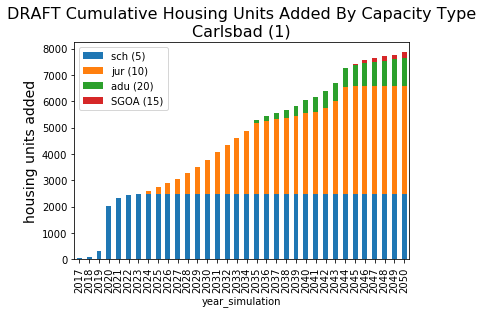

In [9]:
city_cpa_id = 1
jur = 'Carlsbad'



ax = type_pivot.plot.bar(stacked=True)
ptitle = 'DRAFT Cumulative Housing Units Added By Capacity Type\n' + jur + ' (' +  str(city_cpa_id) + ')'
ax.set_ylabel("housing units added",size=14)
ax.set_title(ptitle,size=16) 
orig = ax.legend
#extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend(["sch (5)", "jur (10)","adu (20)","SGOA (15)"]);
#ax.legend([orig,extra], (["sch (5)", "jur (10)","adu (20)","SGOA (15)"],"Total Chg"))
        # create blank rectangle
# extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
# extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
# extra3 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
# ax.legend([ax.legend,extra], (plotlabelsr13,"Total Chg"))

In [10]:
bins = range(2015,2055,5)
names = [str(x) for x in range(2020,2055,5)]

In [11]:
hs2['increment'] = pd.cut(hs2.year_simulation, bins, labels=names)

In [12]:
hs2.head()

,parcel_id,name,cap_jurisdiction_id,jurisdiction_id,mgra_id,luz_id,hs_change,source,capacity_type,year_simulation,increment
0,5054670,Carlsbad,1,1,14090,12,11,1,sch,2017,2020
1,329171,Carlsbad,1,1,14090,12,3,1,sch,2017,2020
2,685559,Carlsbad,1,1,14167,12,1,1,sch,2017,2020
3,684248,Carlsbad,1,1,14090,12,2,1,sch,2017,2020
4,5010042,Carlsbad,1,1,14290,11,7,1,sch,2017,2020


In [13]:
units_added_by_capacity_type_and_yr = pd.DataFrame({'units_by_type': hs2.
                                          groupby(["increment","capacity_type"])
                                          .hs_change.sum()}).reset_index()

In [14]:
units_added_by_capacity_type_and_yr.head()

,increment,capacity_type,units_by_type
0,2020,sch,2042
1,2025,jur,285
2,2025,sch,428
3,2030,jur,1023
4,2035,adu,83


In [53]:
type_pivot = units_added_by_capacity_type_and_yr.pivot\
(index='increment', columns='capacity_type', values='units_by_type').\
reset_index().rename_axis(None, axis=1)

In [54]:
type_pivot.head()

,increment,SGOA,adu,jur,sch
0,2020,NaN,NaN,NaN,2042.0
1,2025,NaN,NaN,285.0,428.0
2,2030,NaN,NaN,1023.0,NaN
3,2035,NaN,83.0,1420.0,NaN
4,2040,NaN,389.0,379.0,NaN


In [55]:
sum_SGOA = int(type_pivot.SGOA.sum())
sum_adu = int(type_pivot.adu.sum())
sum_jur = int(type_pivot.jur.sum())
sum_sch = int(type_pivot.sch.sum())

In [56]:
type_pivot.SGOA.fillna(0,inplace=True)
type_pivot.adu.fillna(0,inplace=True)
type_pivot.jur.fillna(0,inplace=True)
type_pivot.sch.fillna(0,inplace=True)

In [57]:
type_pivot.set_index('increment',inplace=True)
type_pivot = type_pivot[['sch', 'jur', 'adu', 'SGOA']]
type_pivot['sch'] = type_pivot['sch'].cumsum()
type_pivot['jur'] = type_pivot['jur'].cumsum()
type_pivot['adu'] = type_pivot['adu'].cumsum()
type_pivot['SGOA'] = type_pivot['SGOA'].cumsum()

In [38]:
handles

 <Container object of 7 artists>,
 <Container object of 7 artists>,
 <Container object of 7 artists>,
 <Container object of 7 artists>]

In [37]:
labels

['Total added/capacity', u'sch', u'jur', u'adu', u'SGOA']

In [46]:
type_pivot.head()

,sch,jur,adu,SGOA
increment,,,,
2020,2042.0,0.0,0.0,0.0
2025,2470.0,285.0,0.0,0.0
2030,2470.0,1308.0,0.0,0.0
2035,2470.0,2728.0,83.0,0.0
2040,2470.0,3107.0,472.0,0.0


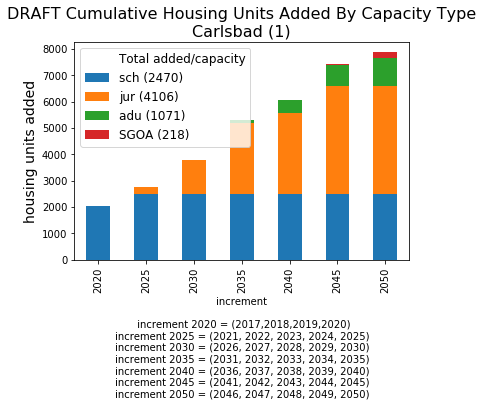

In [60]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

city_cpa_id = 1
jur = 'Carlsbad'

ax = type_pivot.plot.bar(stacked=True)
handles, labels = ax.get_legend_handles_labels()
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles.insert(0,extra)
labels.insert(0,'(added/capacity)')
labels = ['Total added/capacity',\
          'sch (' + str(sum_sch) +')',\
          'jur (' + str(sum_jur) +')',\
          'adu (' + str(sum_adu) +')',\
          'SGOA (' + str(sum_SGOA) +')']
ptitle = 'DRAFT Cumulative Housing Units Added By Capacity Type\n' + jur + ' (' +  str(city_cpa_id) + ')'
ax.set_ylabel("housing units added",size=14)
ax.set_xlabel("increment\n\n increment 2020 = (2017,2018,2019,2020)\nincrement 2025 = (2021, 2022, 2023, 2024, 2025)\
\nincrement 2030 = (2026, 2027, 2028, 2029, 2030)\nincrement 2035 = (2031, 2032, 2033, 2034, 2035)\
\nincrement 2040 = (2036, 2037, 2038, 2039, 2040)\nincrement 2045 = (2041, 2042, 2043, 2044, 2045)\
\nincrement 2050 = (2046, 2047, 2048, 2049, 2050)")
ax.set_title(ptitle,size=16) 

# ax.legend(["sch (5)", "jur (10)","adu (20)","SGOA (15)"]);
leg = ax.legend(handles, labels,fontsize=12)

In [ ]:
hs2.loc[hs2.increment=='2050'].year_simulation.unique()